In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split

import hervpd as hp
import plotReport as pr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data description

In [24]:
df = pd.read_excel('/home/ju/GDrive/Projects/HeRV/Data/PreProcessed/df_90_300.xlsx')
df.describe()

,hf,hfnu,lf,lf_hf,lfnu,mhr,mrri,nn50,order,pnn50,rmssd,sdnn,sess,total_power,user,vlf
count,2.694000e+03,2694.000000,2.694000e+03,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2.694000e+03,2694.000000,2.694000e+03
mean,2.387300e+04,45.815472,4.127698e+05,2.465940,54.184528,78.661621,819.019148,89.473645,18.990720,25.773847,112.382566,114.926574,162.705642,1.475527e+06,1.624722,1.038884e+06
std,1.821238e+05,23.079335,8.977828e+06,4.822733,23.079335,18.109035,173.770072,71.387172,24.864286,22.689257,169.919067,122.765916,117.628292,4.585638e+07,2.009594,3.707927e+07
min,5.751146e-01,1.419545,2.567078e+00,0.027289,2.656368,47.596407,334.157205,0.000000,0.000000,0.000000,3.369205,13.625541,0.000000,3.390064e+01,0.000000,2.559104e+01
25%,3.727382e+02,26.437869,5.863960e+02,0.563744,36.050930,66.002474,703.884813,30.000000,2.000000,7.290387,33.034351,53.887830,63.000000,1.761790e+03,0.000000,5.059374e+02
50%,9.172297e+02,43.726407,1.280138e+03,1.286951,56.273593,77.199486,793.543971,72.000000,7.000000,18.870437,53.744197,77.456919,135.000000,3.576149e+03,1.000000,1.088380e+03
75%,4.668043e+03,63.949070,3.023524e+03,2.782454,73.562131,87.023533,933.362043,136.000000,29.000000,39.789854,131.090808,138.225573,295.000000,1.190274e+04,2.000000,2.524048e+03
max,6.139868e+06,97.343632,4.263838e+08,69.445109,98.580455,180.176325,1269.037344,354.000000,113.000000,91.726619,2239.263240,1776.464653,350.000000,2.338062e+09,6.000000,1.905538e+09


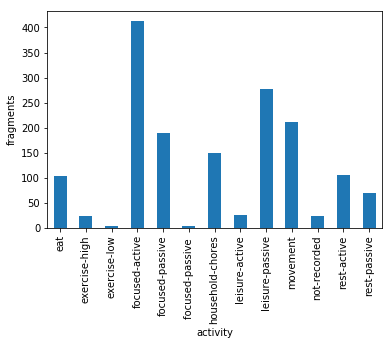

In [25]:
hp.plot_count(df, 'activity', exclude=['sleep'])

## 2A. Data preparation - Inserting labels for aggregating categories:

* 1: move vs still = exercise (high and low intensity), movement, household chores X *others*
* 2: sleep vs awake =  sleep X *others*
* 3: move vs sleep vs stand = Move (from 1) X Sleep (from 2) X *others*


In [26]:
movelist = ['exercise-high', 'exercise-low', 'movement', 'household-chores']
#df = hp.add_partition(df, movelist, pname='move', labelIn='move', labelOut='still')
    
sleeplist = ['sleep']
#df = hp.add_partition(df, sleeplist, pname='sleep', labelIn='sleep', labelOut='wake')

df['sleeping'] = np.where(df['activity'].isin(sleeplist), 1, 0)
df['moving'] = np.where(df['activity'].isin(movelist), 1, 0)
df['still'] = np.where(~df['activity'].isin(movelist) & ~df['activity'].isin(sleeplist), 1, 0)
df['lyingdown'] = np.where(df['posture'].isin(['lie', 'lying down']), 1, 0)
df['sitting'] = np.where(df['posture'].isin(['sit','sitting']), 1, 0)
df['standing'] = np.where(df['posture'].isin(['stand','standing', 'standing ']), 1, 0)


In [27]:
df.sample(20)

,activity,hf,hfnu,lf,lf_hf,lfnu,mhr,mrri,nn50,order,...,stop,total_power,user,vlf,sleeping,moving,still,lyingdown,sitting,standing
479,focused-active,2695.170693,66.343597,1.367272e+03,0.507304,33.656403,73.785314,822.959677,132,6,...,2017-10-15 21:56:22,4.847181e+03,0,7.847383e+02,0,0,1,0,1,0
1072,sleep,9820.313400,71.997101,3.819560e+03,0.388945,28.002899,92.334969,747.578049,235,4,...,2017-10-04 11:50:30,1.778475e+04,0,4.144878e+03,1,0,0,1,0,0
125,focused-active,194.365678,31.947794,4.140196e+02,2.130107,68.052206,92.709087,649.624204,15,0,...,2017-10-14 18:10:30,9.890172e+02,0,3.806319e+02,0,0,1,0,1,0
587,focused-active,281.301581,46.528693,3.232750e+02,1.149211,53.471307,84.649691,710.993039,26,1,...,2017-11-09 13:52:11,1.004016e+03,0,3.994398e+02,0,0,1,0,1,0
1377,leisure-passive,35178.388459,29.734945,8.312817e+04,2.363046,70.265055,70.378932,871.212465,62,12,...,2017-10-30 01:42:10,1.493199e+05,1,3.101330e+04,0,0,1,0,1,0
828,movement,386.291038,37.653973,6.396061e+02,1.655762,62.346027,90.095691,670.947230,21,19,...,2017-10-12 12:05:52,1.955152e+03,0,9.292545e+02,0,1,0,0,0,1
1144,focused-passive,20630.623176,48.097589,2.226264e+04,1.079106,51.902411,71.469826,870.321937,193,33,...,2017-10-05 12:26:13,4.512889e+04,0,2.235629e+03,0,0,1,0,1,0
847,rest-active,815.058350,39.943069,1.225492e+03,1.503563,60.056931,95.463464,636.221992,38,2,...,2017-10-12 14:25:47,3.141356e+03,0,1.100806e+03,0,0,1,0,1,0
737,sleep,10196.371570,83.353656,2.036291e+03,0.199707,16.646344,57.652157,1057.234483,205,81,...,2017-10-11 08:28:40,1.327269e+04,0,1.040027e+03,1,0,0,1,0,0
1766,not-recorded,3321.407477,62.506090,1.992327e+03,0.599844,37.493910,82.763434,736.711538,54,2,...,2017-10-17 18:27:30,6.035122e+03,2,7.213881e+02,0,0,1,0,1,0


In [28]:
hp.count_by(df, 'sleeping')

sleeping
0    1604
1    1090
Name: user, dtype: int64

In [29]:
hp.count_by(df, 'moving')

moving
0    2304
1     390
Name: user, dtype: int64

In [30]:
hp.count_by(df, 'still')

still
0    1480
1    1214
Name: user, dtype: int64

In [31]:
hp.count_by(df, 'lyingdown')

lyingdown
0    1564
1    1130
Name: user, dtype: int64

In [32]:
hp.count_by(df, 'standing')

standing
0    2304
1     390
Name: user, dtype: int64

In [33]:
hp.count_by(df, 'sitting')

sitting
0    1546
1    1148
Name: user, dtype: int64

## 2B. Data preparation - scaling and splitting test and train datasets

In [83]:
feature_list = ['hf', 'hfnu', 'lf', 'lf_hf', 'lfnu', 'mhr', 'mrri', 'nn50', 'hf', 'pnn50', 'rmssd', 'sdnn', 'total_power', 'vlf']
one_hot_labels = ['moving', 'sleeping', 'still', 'sitting', 'standing', 'lyingdown']
all_labels = ['activity', 'posture', 'moving', 'sleeping', 'still', 'sitting', 'standing', 'lyingdown']
train, test = hp.preprocess(df, feature_list)
ttu = [hp.preprocess(hp.user_data(df, user), feature_list) for user in range(7)]

2155 539
1028 258
242 61
352 89
43 11
161 41
180 46
145 37


In [84]:
print ([(len(ttu[i][0]), len(ttu[i][1])) for i in range(7)])

[(1028, 258), (242, 61), (352, 89), (43, 11), (161, 41), (180, 46), (145, 37)]


## 3. SVM classification - Moving vs still (including sleep in still activities)

In [65]:
label='activity'
C1, C2, gamma = hp.model_selection_svm(df, feature_list, labelName=label)

2155 539
Best params for linear kernel: {'C': 100.0} with score 0.90603
Best params for RBF kernel: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.90371


### 3A. For all users combined

In [85]:
for label in all_labels:
    clf_svm = hp.clf_svm_rbf(train, feature_list, labelName=label, C=C2, gamma=gamma)
    print(label, ': ', hp.report_test(clf_svm, test, feature_list, labels=[label], print_report=False, plot_report=False))

/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 14, does not match size of target_names, 2
  .format(len(labels), len(target_names))
/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


activity :  0.552875695733


/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 8, does not match size of target_names, 2
  .format(len(labels), len(target_names))


posture :  0.701298701299
moving :  0.907235621521
sleeping :  0.890538033395
still :  0.807050092764
sitting :  0.808905380334
standing :  0.909090909091
lyingdown :  0.894248608534


### 3B. For each user (SVM moving x still)

In [66]:
label='moving'
for user in [0,1,2,3,5]:
    train_u, test_u = ttu[user]
    print ('---------------- User: ', user, ' ----------------------')
    clf_svm = hp.clf_svm_rbf(train_u, feature_list, labelName=label, C=C2, gamma=gamma)
    print(hp.report_test(clf_svm, test_u, feature_list, labels=[label], print_report=True, plot_report=False), '\n')

---------------- User:  0  ----------------------
             precision    recall  f1-score   support

 not moving       0.93      0.94      0.94       208
     moving       0.73      0.72      0.73        50

avg / total       0.89      0.90      0.89       258

0.895348837209 

---------------- User:  1  ----------------------
             precision    recall  f1-score   support

 not moving       1.00      0.96      0.98        56
     moving       0.71      1.00      0.83         5

avg / total       0.98      0.97      0.97        61

0.967213114754 

---------------- User:  2  ----------------------
             precision    recall  f1-score   support

 not moving       0.92      0.99      0.95        79
     moving       0.75      0.30      0.43        10

avg / total       0.90      0.91      0.89        89

0.910112359551 

---------------- User:  3  ----------------------
             precision    recall  f1-score   support

 not moving       1.00      0.86      0.92        

### 3C. For each user (SVM awake  x sleep)

In [74]:
label='sleeping'
for user in df.loc[df[label]==1].user.unique(): #users that have sleep data
    train_u, test_u = ttu[user]
    print ('---------------- User: ', user, ' ----------------------')
    clf_svm = hp.clf_svm_rbf(train_u, feature_list, labelName=label, C=C2, gamma=gamma)
    print(hp.report_test(clf_svm, test_u, feature_list, labels=[label], print_report=True, plot_report=False), '\n')

---------------- User:  0  ----------------------
              precision    recall  f1-score   support

not sleeping       0.88      0.98      0.92       137
    sleeping       0.97      0.84      0.90       121

 avg / total       0.92      0.91      0.91       258

0.914728682171 

---------------- User:  1  ----------------------
              precision    recall  f1-score   support

not sleeping       0.94      0.98      0.96        52
    sleeping       0.86      0.67      0.75         9

 avg / total       0.93      0.93      0.93        61

0.934426229508 

---------------- User:  2  ----------------------
              precision    recall  f1-score   support

not sleeping       0.92      0.97      0.95        71
    sleeping       0.86      0.67      0.75        18

 avg / total       0.91      0.91      0.91        89

0.910112359551 

---------------- User:  4  ----------------------
              precision    recall  f1-score   support

not sleeping       0.88      0.70    

## 5. Random Forest classifier 

### 4A. For each label separately

In [86]:
for label in all_labels:
    clf = hp.clf_rf(train, feature_list, labels=[label])
    print(label, ': ', clf.score(X=test[feature_list], y=test[label]))

/home/ju/workspace/HeRV_analysis/hervpd.py:106: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X=df_train[features], y=df_train[labels])


activity :  0.582560296846


/home/ju/workspace/HeRV_analysis/hervpd.py:106: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X=df_train[features], y=df_train[labels])


posture :  0.699443413729


/home/ju/workspace/HeRV_analysis/hervpd.py:106: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X=df_train[features], y=df_train[labels])


moving :  0.91280148423


/home/ju/workspace/HeRV_analysis/hervpd.py:106: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X=df_train[features], y=df_train[labels])


sleeping :  0.881261595547


/home/ju/workspace/HeRV_analysis/hervpd.py:106: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X=df_train[features], y=df_train[labels])


still :  0.799628942486


/home/ju/workspace/HeRV_analysis/hervpd.py:106: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X=df_train[features], y=df_train[labels])


sitting :  0.807050092764


/home/ju/workspace/HeRV_analysis/hervpd.py:106: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X=df_train[features], y=df_train[labels])


standing :  0.899814471243


/home/ju/workspace/HeRV_analysis/hervpd.py:106: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X=df_train[features], y=df_train[labels])


lyingdown :  0.894248608534


### 4B. For multi-1-hot encoded labels

             precision    recall  f1-score   support

     moving       0.63      0.71      0.67        65
   sleeping       0.88      0.79      0.83       211
      still       0.80      0.77      0.78       263
    sitting       0.81      0.76      0.78       247
   standing       0.60      0.68      0.64        65
  lyingdown       0.90      0.82      0.86       221

avg / total       0.82      0.77      0.79      1072

[0.63, 0.71, 0.67]
[0.88, 0.79, 0.83]
[0.8, 0.77, 0.78]
[0.81, 0.76, 0.78]
[0.6, 0.68, 0.64]
[0.9, 0.82, 0.86]


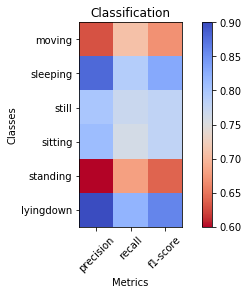

0.725417439703 



In [91]:
clf = hp.clf_rf(train, feature_list, labels=one_hot_labels)
print(hp.report_test(clf, test, feature_list, labels=one_hot_labels, print_report=True, plot_report=True), '\n')

In [ ]:
for user in [0,1,2,5,6]: 
    print('-------------- USER: ', user, '--------------')
    dfu = hp.user_data(df, user)
    clf = hp.clf_rf(train, feature_list, labels=one_hot_labels)
    print(clf.score(X=test[feature_list], y=test[one_hot_labels]))
    
    

In [ ]:
df_wake = hp.filter_out(df, 'is_asleep', [1])
labels.remove('is_asleep')
labels.remove('is_lyingdown')
print(labels)

In [ ]:
hp.run_rf(df_wake, feature_list, labels, print_report=True, plot_report=True)

In [ ]:
for user in [0,1,2,5,6]: 
    print('-------------- USER: ', user, '--------------')
    dfu = hp.user_data(df_wake, user)
    uscore = hp.run_rf(dfu, feature_list, labels, plot_report=True)
    print(uscore, '\n\n')